# UNI2-h → PixCell (gated) : LoRA + adaptateur de conditionnement
Notebook clean, basé sur 07_Diffusion_model (gated), adapté à la version publique de PixCell.<br>
Adaptation: UNI2-h réel en entrée + pipeline PixCell “gated” en diffusion, avec LoRA seulement sur les cross-attn et, si besoin, un mini-adapter pour faire correspondre la dimension.

## Cellule 1 — Imports, chemins, seed, device

In [1]:
# %% [markdown]
# # UNI2-h → PixCell (public) : LoRA + adaptateur de conditionnement
# Notebook clean, basé sur 07_Diffusion_model (gated), adapté à la version publique de PixCell.

# %% 
from pathlib import Path
import os, sys, math, json, random, gc
import numpy as np
from PIL import Image
from typing import List, Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Diffusers (UNet conditionnel + scheduler + LoRA processors)
from diffusers import UNet2DConditionModel, DDPMScheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
from torchvision.utils import make_grid, save_image

# Reproductibilité + device
SEED = int(os.getenv("SEED", 42))
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device: {DEVICE}")

# Dossiers (notebook dans /notebook, projet = parent)
NOTEBOOK_DIR = Path.cwd().resolve()
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", NOTEBOOK_DIR.parent)).resolve()
DATA_PATH     = Path(os.getenv("DATA_PATH", PROJECT_ROOT / "data")).resolve()
CONFIG_DIR    = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "config")).resolve()
os.environ["CONFIG_DIR"] = str(CONFIG_DIR)  # important pour HistoDataset

print("PROJECT_ROOT:", PROJECT_ROOT)
print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("DATA_PATH   :", DATA_PATH)
print("CONFIG_DIR  :", CONFIG_DIR)

# Prépare le sys.path pour importer ton DataGenerator et mappings
sys.path.insert(0, str(PROJECT_ROOT / "p9dg"))
sys.path.insert(0, str(PROJECT_ROOT))  # au cas où

# Imports projet (DataGenerator + Sampler équilibré)
from histo_dataset import HistoDataset, BalancedRoundRobinSampler  # noqa
try:
    from p9dg.utils.class_mappings import class_labels, make_idx_mappings
except Exception:
    class_labels = None
    def make_idx_mappings(class_to_idx):
        return {i: str(i) for _, i in class_to_idx.items()}, {}, {}


✅ Device: cuda
PROJECT_ROOT: /workspace
NOTEBOOK_DIR: /workspace/notebooks
DATA_PATH   : /workspace/data
CONFIG_DIR  : /workspace/configs


## Cellule 2 — Config experte (classes, tailles, checkpoints)

In [2]:
# %%
import os
from pathlib import Path

# ----- Classes / dataset -----
CLASSES_USED = [c.strip() for c in os.getenv("CLASSES_USED", "TUM").split(",") if c.strip()]

# ----- I/O & tailles -----
IMG_SIZE    = int(os.getenv("IMG_SIZE", 256))
BATCH_SIZE  = int(os.getenv("BATCH_SIZE", 2))     # micro-batch
NUM_WORKERS = int(os.getenv("NUM_WORKERS", 0))    # 0 pour éviter le multiprocessing en container CUDA/Jupyter

# ----- LoRA & entraînement -----
LORA_RANK     = int(os.getenv("LORA_RANK", 8))
LR            = float(os.getenv("LR", 1e-4))
WEIGHT_DECAY  = float(os.getenv("WEIGHT_DECAY", 1e-4))
MAX_STEPS     = int(os.getenv("MAX_STEPS", 400))
LOG_EVERY     = int(os.getenv("LOG_EVERY", 25))
MAX_GRAD_NORM = float(os.getenv("MAX_GRAD_NORM", 1.0))
CFG_DROP_PROB = float(os.getenv("CFG_DROP_PROB", 0.15))   # prob. de drop du cond (CFG-drop)
L2_LAMBDA     = float(os.getenv("L2_LAMBDA", 1e-6))

# ----- Racine projet -----
if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd()

# ----- Dossier de sortie des adapters -----
CKPT_DIR = PROJECT_ROOT / "checkpoints" / "pixcell_lora_adapter_public"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# ----- UNI2-h (réutilisation de la sauvegarde du notebook 07) -----
# Tu peux override avec:  UNI2H_DIR=/chemin/vers/ta/sauvegarde_uni2h_nb07
_default_uni_dirs = [
    PROJECT_ROOT / "checkpoints" / "uni2h_nb07",
    PROJECT_ROOT / "weights"     / "uni2h_nb07",
    PROJECT_ROOT / "artifacts"   / "uni2h_nb07",
]
UNI2H_DIR = Path(os.getenv("UNI2H_DIR", "")).expanduser()
if not UNI2H_DIR:
    UNI2H_DIR = next((p for p in _default_uni_dirs if p.exists()), _default_uni_dirs[0])
UNI2H_DIR = UNI2H_DIR.resolve()

# ----- Log rapide -----
print(f"Classes utilisées : {CLASSES_USED}")
print(f"IMG_SIZE={IMG_SIZE} | BATCH_SIZE={BATCH_SIZE} | NUM_WORKERS={NUM_WORKERS}")
print(f"LoRA rank={LORA_RANK} | LR={LR} | WD={WEIGHT_DECAY} | MAX_STEPS={MAX_STEPS}")
print(f"CFG_DROP_PROB={CFG_DROP_PROB} | L2_LAMBDA={L2_LAMBDA}")
print("Dossier adapters :", CKPT_DIR)
print("UNI2-h (Notebook 07) :", UNI2H_DIR)

# --- La suite 'Checkpoints...' est déplacée en Cellule 2b ---


Classes utilisées : ['TUM']
IMG_SIZE=256 | BATCH_SIZE=2 | NUM_WORKERS=0
LoRA rank=8 | LR=0.0001 | WD=0.0001 | MAX_STEPS=400
CFG_DROP_PROB=0.15 | L2_LAMBDA=1e-06
Dossier adapters : /workspace/checkpoints/pixcell_lora_adapter_public
UNI2-h (Notebook 07) : /workspace/notebooks


### Cellule 2b — Checkpoints PixCell

In [3]:
# %%
# --- Checkpoints PixCell (Diffusers) + UNI2-h (local) ---

import os
from pathlib import Path

# Racines
CKPT_ROOT = Path(os.getenv("CKPT_ROOT", "/workspace/checkpoints")).resolve()

# Dossiers PixCell (pipeline exportée depuis 07) et code custom
PIXCELL_DIR     = Path(os.getenv("PIXCELL_DIR", CKPT_ROOT / "pixcell256-gated")).resolve()
CUSTOM_PIPE_DIR = Path(os.getenv("CUSTOM_PIPE_DIR", CKPT_ROOT / "custom_pipelines" / "PixCell-pipeline")).resolve()

# UNI2-h — réutilise le dossier sauvegardé depuis 07 (déjà défini plus haut normalement)
# Si tu veux forcer un chemin : export UNI2H_DIR=/ton/chemin
UNI2H_DIR = Path(os.getenv("UNI2H_DIR", str(UNI2H_DIR))).resolve()  # garde la valeur de la Cellule 2 si présente

def _exists_any(d: Path, candidates):
    for c in candidates:
        p = d / c
        if p.exists():
            return p
    return None

# Fichiers attendus côté pipeline Diffusers
model_index = PIXCELL_DIR / "model_index.json"
tr_dir = PIXCELL_DIR / "transformer"
vae_dir = PIXCELL_DIR / "vae"

tr_w = _exists_any(tr_dir, ["diffusion_pytorch_model.safetensors", "diffusion_pytorch_model.bin"])
vae_w = _exists_any(vae_dir, ["diffusion_pytorch_model.safetensors", "diffusion_pytorch_model.bin"])

# Logs + validations
print(f"PixCell dir        : {PIXCELL_DIR}")
print(f"  model_index.json : {'OK' if model_index.exists() else '❌'}")
print(f"  transformer ckpt : {tr_w.name if tr_w else '❌'}")
print(f"  vae ckpt         : {vae_w.name if vae_w else '❌'}")
print(f"Custom pipeline dir: {CUSTOM_PIPE_DIR} ({'OK' if CUSTOM_PIPE_DIR.exists() else '❌'})")
print(f"UNI2-h dir         : {UNI2H_DIR} ({'OK' if UNI2H_DIR.exists() else '❌'})")

errors = []
if not model_index.exists():
    errors.append(f"manquant: {model_index}")
if not tr_w:
    errors.append(f"manquant: poids transformer dans {tr_dir}")
if not vae_w:
    errors.append(f"manquant: poids VAE dans {vae_dir}")
if not CUSTOM_PIPE_DIR.exists():
    errors.append(f"manquant: code custom PixCell dans {CUSTOM_PIPE_DIR}")
if not UNI2H_DIR.exists():
    errors.append(f"manquant: dossier UNI2-h dans {UNI2H_DIR}")

if errors:
    raise FileNotFoundError(" | ".join(errors))


PixCell dir        : /workspace/checkpoints/pixcell256-gated
  model_index.json : OK
  transformer ckpt : diffusion_pytorch_model.safetensors
  vae ckpt         : diffusion_pytorch_model.safetensors
Custom pipeline dir: /workspace/checkpoints/custom_pipelines/PixCell-pipeline (OK)
UNI2-h dir         : /workspace/notebooks (OK)


### Charge UNI2-h (sauvegardé en local)

In [4]:
from pathlib import Path
import os

# 👉 adapte ce chemin si besoin (ou via: export UNI2H_DIR=/workspace/ckpts/UNI2-h)
UNI2H_DIR = Path(os.getenv("UNI2H_DIR", "/workspace/ckpts/UNI2-h")).resolve()

def _has_uni_files(d: Path):
    return any((d / fn).exists() for fn in ["pytorch_model.bin", "model.safetensors", "config.json", "preprocessor_config.json"])

print("UNI2-h dir :", UNI2H_DIR, "| OK" if (UNI2H_DIR.exists() and _has_uni_files(UNI2H_DIR)) else "❌ vérifier le chemin")


UNI2-h dir : /workspace/ckpts/UNI2-h | OK


In [5]:
import torch, timm
from huggingface_hub import hf_hub_download
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE  = torch.float32   # rester en fp32 côté encodeur

# Hyperparams officiels UNI2-h (identiques à ton autre notebook)
timm_kwargs = dict(
    img_size=224, patch_size=14, depth=24, num_heads=24,
    init_values=1e-5, embed_dim=1536, mlp_ratio=2.66667 * 2,
    num_classes=0, no_embed_class=True, mlp_layer=timm.layers.SwiGLUPacked,
    act_layer=torch.nn.SiLU, reg_tokens=8, dynamic_img_size=True,
)

# 1) essai direct via timm (cache local HF)
model = None
try:
    model = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
except Exception as e:
    print(f"[info] create_model(hf-hub) a échoué: {e}\n→ fallback lecture state_dict local")
    # 2) fallback: charge state_dict depuis UNI2H_DIR
    ckpt = None
    for fn in ["pytorch_model.bin", "model.safetensors"]:
        p = UNI2H_DIR / fn
        if p.exists():
            ckpt = p; break
    if ckpt is None:
        raise FileNotFoundError(f"Aucun poids UNI2-h trouvé dans {UNI2H_DIR}")
    model = timm.create_model(pretrained=False, **timm_kwargs)
    state = torch.load(ckpt, map_location="cpu")
    model.load_state_dict(state, strict=True)

model.eval().to(DEVICE, dtype=DTYPE)

data_cfg = resolve_data_config(model.pretrained_cfg, model=model)
uni_tf = create_transform(**data_cfg)

# smoke test
with torch.inference_mode():
    y = model(torch.randn(2,3,224,224, device=DEVICE, dtype=DTYPE))
print("✅ UNI2-h OK | out:", tuple(y.shape), "| device:", DEVICE, "| dtype:", DTYPE)


✅ UNI2-h OK | out: (2, 1536) | device: cuda | dtype: torch.float32


## Cellule 3 — Dataset & DataLoader (sampling équilibré, sélection de classes)

In [6]:
# %%
# Dataset train : sampling équilibré + N images par classe / epoch
SAMPLES_PER_CLASS = 100,   # ← était 200 on peut aller à 1000+

train_ds = HistoDataset(
    root_data=str(DATA_PATH),
    split="train",
    output_size=IMG_SIZE,
    pixel_range="-1_1",                # utile en diffusion (échelle [-1,1])
    balance_per_class=True,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS,
    vahadane_enable=True,
    classes=CLASSES_USED,              # <— sélection de classes
    apply_quality_filter=True,         # filtrage activé sur train (comme d'hab)
    thresholds_json_path="seuils_par_classe.json",  # lu via CONFIG_DIR
    return_labels=True,
)
print("✅ Classes et effectifs:", train_ds.class_counts())
idx_to_name, _, _ = make_idx_mappings(train_ds.class_to_idx)

# Sampler round-robin (équilibre parfait des batches)
train_sampler = BalancedRoundRobinSampler(train_ds, seed=SEED)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, sampler=train_sampler,
    num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"), drop_last=True
)
# Petit test itérable
xb, yb, pb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape, "ex. paths[0] →", pb[0])


[⚠️] Valeur invalide pour samples_per_class_per_epoch ((100,)), ignorée.
🎨 Référence Vahadane fixée : TUM-RAGCWCVP.tif
🎨 Référence Vahadane auto: TUM-RAGCWCVP.tif
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré auto (14317 images / classe, min du dataset).
✅ Classes et effectifs: {'TUM': 14317}
Batch: torch.Size([2, 3, 256, 256]) torch.Size([2]) ex. paths[0] → /workspace/data/NCT-CRC-HE-100K/TUM/TUM-RQYNISVV.tif


### Cellule 4 — Visualisation éclair (grille)

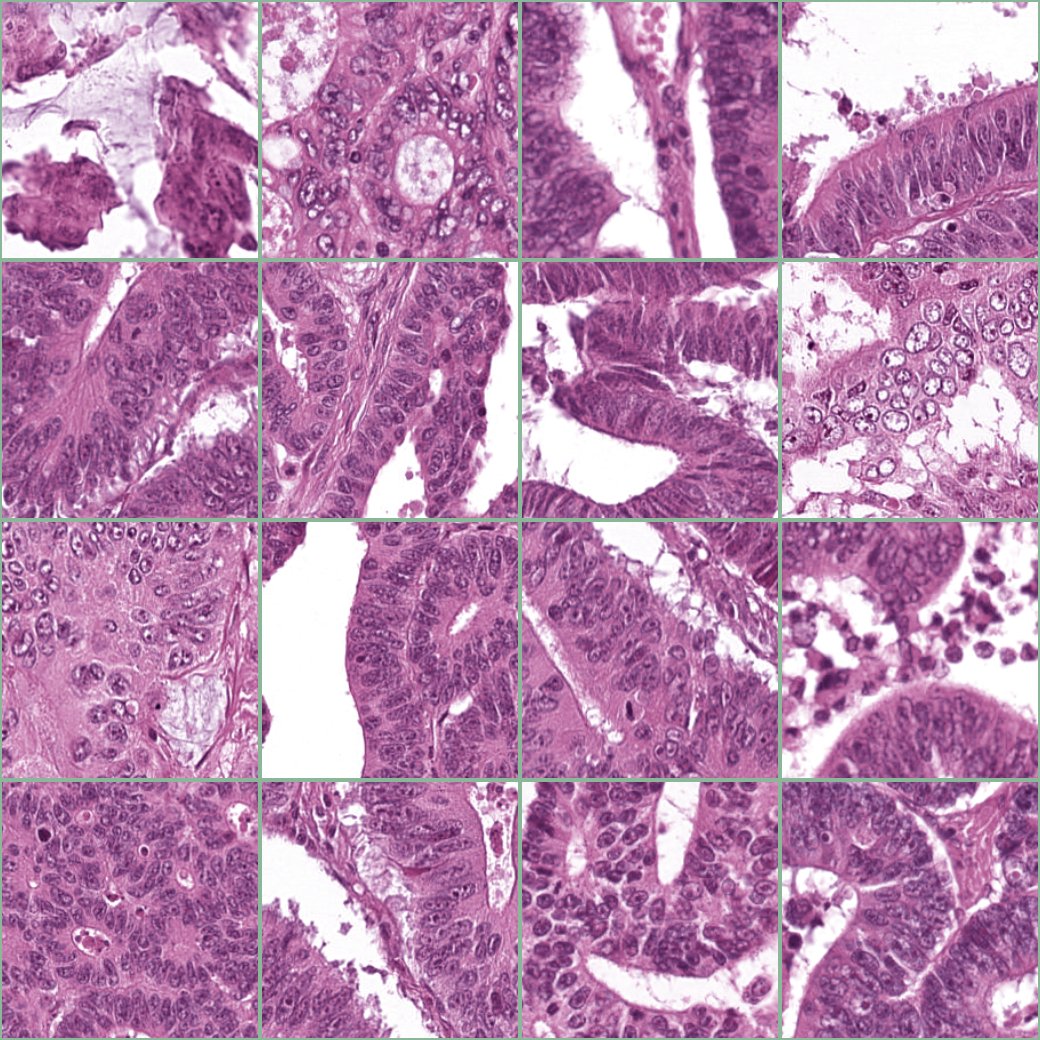

In [7]:
# %%
# Aperçu rapide (optionnel)
grid_img = train_ds.vis(n=16)
display(grid_img)


## Cellule 5 — Adaptateur de conditionnement (classe → embedding UNI-like)

In [8]:
# %%
# La version publique de PixCell reste "conditionnelle" dans l'esprit,
# on prépare un embedding au format attendu par l'UNet (cross_attention_dim).
CROSS_ATTN_DIM = 1536  # format UNI2-h (observé précédemment)

class ClassConditionalAdapter(nn.Module):
    """
    Mappe un id de classe -> embedding [B, 1, CROSS_ATTN_DIM], via (Embedding -> MLP).
    """
    def __init__(self, num_classes: int, cross_dim: int = CROSS_ATTN_DIM, hidden: int = 512):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=num_classes, embedding_dim=hidden)
        self.proj = nn.Sequential(
            nn.Linear(hidden, hidden * 2), nn.SiLU(),
            nn.Linear(hidden * 2, cross_dim),
        )
        self.norm = nn.LayerNorm(cross_dim)

    def forward(self, y: torch.Tensor) -> torch.Tensor:
        # y: [B] int64
        h = self.emb(y)              # [B, H]
        h = self.proj(h)             # [B, cross_dim]
        h = self.norm(h)
        return h.unsqueeze(1)        # [B, 1, cross_dim]

num_classes = len(train_ds.class_to_idx)
adapter = ClassConditionalAdapter(num_classes=num_classes, cross_dim=CROSS_ATTN_DIM).to(DEVICE)

# Test rapide
with torch.no_grad():
    ytest = torch.randint(0, num_classes, (4,), device=DEVICE)
    etest = adapter(ytest)
print("Adapter out:", etest.shape)   # [4, 1, 1536]


Adapter out: torch.Size([4, 1, 1536])


## Cellule 6 — Chargement UNet (PixCell public) + injection LoRA

In [11]:
# %% [markdown]
# Cellule 6 — Mode "UNI direct" : geler UNI, charger PixCell locale, loader TIFF robuste, sampling via `uni_embeds`

import os
from pathlib import Path
from typing import Sequence, Union

import numpy as np
import torch
from PIL import Image
from diffusers import DiffusionPipeline

# ---------------------------------------
# 0) UNI2-h : gel complet
# (on suppose `model` et `uni_tf` définis en Cellule 4)
# ---------------------------------------
for p in model.parameters():
    p.requires_grad_(False)
model.eval()
print("✅ UNI2-h gelé")

# ---------------------------------------
# 1) Charger PixCell locale (export du notebook 07) + code custom
# (PIXCELL_DIR et CUSTOM_PIPE_DIR validés en Cellule 2b)
# ---------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device == "cuda" else torch.float32

pipe = DiffusionPipeline.from_pretrained(
    PIXCELL_DIR,
    custom_pipeline=str(CUSTOM_PIPE_DIR),   # chemin vers le code .py local de la pipeline
    trust_remote_code=True,
    torch_dtype=dtype,
).to(device)

# --- 6.a) Lire la config PixCell et préparer l'adapter UNI->tokens ---
import torch.nn as nn

cfg = getattr(pipe, "transformer", None).config
# N = nb de tokens attendus; Dpix = dim d'embedding côté PixCell
N_TOK = int(getattr(cfg, "caption_num_tokens", 8))
D_PIX = int(
    getattr(cfg, "caption_embed_dim", 0)
    or getattr(cfg, "uni_embed_dim", 0)
    or getattr(cfg, "hidden_size", 1536)
)

UNI_DIM = 1536  # sortie d'UNI2-h (ta Cellule 4)

print(f"PixCell attend uni_embeds de forme (B, {N_TOK}, {D_PIX})")

class UniToTokens(nn.Module):
    """
    Projette un vecteur UNI [B, UNI_DIM] vers N tokens [B, N_TOK, D_PIX].
    Simple: Linear + positions apprises; pas d'entraînement pour l'instant.
    """
    def __init__(self, in_dim=UNI_DIM, out_dim=D_PIX, n_tok=N_TOK):
        super().__init__()
        self.proj = nn.Linear(in_dim, out_dim, bias=True) if in_dim != out_dim else nn.Identity()
        self.pos  = nn.Embedding(n_tok, out_dim)

        # init douce
        if isinstance(self.proj, nn.Linear):
            nn.init.kaiming_uniform_(self.proj.weight, a=math.sqrt(5))
            nn.init.zeros_(self.proj.bias)
        nn.init.zeros_(self.pos.weight)

    def forward(self, uni_feat):  # [B, UNI_DIM]
        B = uni_feat.size(0)
        base = self.proj(uni_feat)              # [B, D_PIX]
        tokens = base.unsqueeze(1).expand(B, N_TOK, D_PIX)  # [B, N_TOK, D_PIX]
        tokens = tokens + self.pos.weight.unsqueeze(0)      # + positions
        return tokens

import math
uni_to_tokens = UniToTokens(UNI_DIM, D_PIX, N_TOK).to(device)
# gel pour l’instant (on adaptera/entraînera plus tard si besoin)
for p in uni_to_tokens.parameters():
    p.requires_grad_(False)


# Optionnel : scheduler plus stable (ne casse rien si indisponible)
try:
    from diffusers import DPMSolverMultistepScheduler
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
except Exception:
    pass

print(f"✅ PixCell locale chargée | device={device} | dtype={dtype}")

# ---------------------------------------
# 2) Loader robuste pour PNG/JPG/TIFF (8/16 bits, mono/multi-page)
# ---------------------------------------
try:
    import tifffile as tiff
    _HAS_TIFFILE = True
except Exception:
    _HAS_TIFFILE = False

def load_pil_rgb(path: Union[str, Path], page: int = 0, max_edge: int | None = None) -> Image.Image:
    """
    Ouvre un fichier image (png/jpg/tif), gère 8/16 bits, mono/multi-page,
    convertit en RGB uint8 (adapté à l'encodeur UNI2-h).
    - page: index de page pour TIFF multi-pages (0 par défaut)
    - max_edge: limite facultative du plus grand côté (évite les giga-images)
    """
    p = Path(path)
    ext = p.suffix.lower()

    if _HAS_TIFFILE and ext in {".tif", ".tiff"}:
        arr = tiff.imread(str(p), key=page)  # (H,W) ou (H,W,C)
        if arr.ndim == 2:                      # gris -> RGB
            arr = np.stack([arr]*3, axis=-1)
        elif arr.ndim == 3 and arr.shape[-1] > 3:  # plus de 3 canaux -> garde les 3 premiers
            arr = arr[..., :3]

        # Cast en uint8
        if arr.dtype != np.uint8:
            if np.issubdtype(arr.dtype, np.integer):
                maxv = np.iinfo(arr.dtype).max
                arr = (np.clip(arr.astype(np.float32) / float(maxv), 0, 1) * 255.0 + 0.5).astype(np.uint8)
            else:
                arr = (np.clip(arr, 0.0, 1.0) * 255.0 + 0.5).astype(np.uint8)

        img = Image.fromarray(arr, mode="RGB")
    else:
        img = Image.open(p)
        if getattr(img, "n_frames", 1) > 1 and ext in {".tif", ".tiff"}:
            try:
                img.seek(page)
            except Exception:
                pass
        img = img.convert("RGB")

    if max_edge is not None:
        img.thumbnail((max_edge, max_edge), Image.BICUBIC)

    return img

# ---------------------------------------
# 3) Embeddings UNI2-h -> [B, 1536] (fp32), puis cast -> dtype/device PixCell
# ---------------------------------------
def uni_embed_from_paths(paths: Sequence[Union[str, Path]], page: int = 0) -> torch.Tensor:
    ims = [load_pil_rgb(p, page=page) for p in paths]
    xs = [uni_tf(im) for im in ims]  # transform timm (Cellule 4)
    xb = torch.stack(xs).to(next(model.parameters()).device, dtype=torch.float32)  # encodeur en fp32
    with torch.inference_mode():
        feats = model(xb).float()  # [B, 1536]
    return feats.to(device, dtype=dtype)  # cast -> pipeline

# ---------------------------------------
# 4) Sampling via `uni_embeds`
# ---------------------------------------
# --- helpers taille / AR ---
import math
import torch

def _build_size_cond(batch_size: int, h: int, w: int, device, dtype):
    # resolution: (B, 2) en float32 (la plupart des implémentations attendent fp32)
    res = torch.tensor([[h, w]], device=device, dtype=torch.float32).repeat(batch_size, 1)
    # aspect_ratio (essai 1): float ratio (B,)
    ar_float = torch.full((batch_size,), float(w) / float(h), device=device, dtype=torch.float32)
    return res, ar_float

def _ar_bucket_ids(h: int, w: int, batch_size: int, device, num_bins: int = 32):
    # bucketisation logarithmique (fallback si la pipeline attend des IDs entiers)
    r = max(min(float(w) / float(h), 4.0), 0.25)  # clamp sur une plage raisonnable
    # mapping log pour couvrir uniformément la plage
    t = (math.log2(r / 0.25) / math.log2(4.0 / 0.25))  # ∈ [0,1]
    idx = int(round(t * (num_bins - 1)))
    return torch.tensor([idx] * batch_size, device=device, dtype=torch.long)

@torch.no_grad()
def sample_from_uni(
    paths,
    steps: int = 28,
    guidance: float = 1.5,
    size: int = 256,
    seed: int = 321,
    page: int = 0,
):
    import inspect, torch

    # 1) Embedding UNI -> [B,1536] sur device/dtype de la pipeline
    uni_vec = uni_embed_from_paths(paths, page=page)     # [B,1536]
    B, D = uni_vec.shape

    # 2) N tokens attendus par PixCell (depuis la config du TRANSFORMER)
    N_TOK = int(getattr(pipe.transformer.config, "caption_num_tokens", 1))

    # 3) Répéter le vecteur UNI sur N tokens -> [B, N_TOK, 1536]
    emb = uni_vec.unsqueeze(1).expand(B, N_TOK, D).to(device=device, dtype=dtype)

    # 4) Negative UNI (unconditional) — signature robuste
    uncond = None
    if hasattr(pipe, "get_unconditional_embedding"):
        try:
            sig = inspect.signature(pipe.get_unconditional_embedding)
            uncond = pipe.get_unconditional_embedding(batch_size=B) if "batch_size" in sig.parameters else pipe.get_unconditional_embedding(B)
        except Exception:
            pass
    if uncond is None:
        uncond = torch.zeros_like(emb)
    # Harmonise forme/dtype/device
    if uncond.ndim == 2:  # [B,D] -> [B,1,D] -> [B,N,D]
        uncond = uncond.unsqueeze(1)
    if uncond.shape[1] == 1 and N_TOK > 1:
        uncond = uncond.expand(B, N_TOK, uncond.shape[-1])
    uncond = uncond.to(device=device, dtype=emb.dtype)

    # 5) *** CLÉ *** : préparer resolution/aspect_ratio via le TRANSFORMER (comme en 07)
    #    -> tensors 1D (B,) en fp32, formatés exactement comme il attend.
    try:
        added_cond_kwargs = pipe.transformer.prepare_added_cond_kwargs(
            batch_size=B,
            height=size,
            width=size,
            dtype=torch.float32,     # size embeddings en fp32
            device=device,
        )
    except AttributeError:
        # Si jamais la méthode n'existe pas (peu probable ici), on reproduit le format attendu:
        resolution   = torch.full((B,), float(size), device=device, dtype=torch.float32)
        aspect_ratio = torch.full((B,), 1.0,        device=device, dtype=torch.float32)
        added_cond_kwargs = {"resolution": resolution, "aspect_ratio": aspect_ratio}

    # 6) Appel pipeline
    gen = torch.Generator(device=device).manual_seed(seed)
    out = pipe(
        uni_embeds=emb,                      # [B,N,D]
        negative_uni_embeds=uncond,          # [B,N,D]
        guidance_scale=guidance,
        num_inference_steps=steps,
        height=size,
        width=size,
        added_cond_kwargs=added_cond_kwargs, # *** exactement comme en 07 ***
        generator=gen,
    )
    return out.images






print("✅ Mode 'UNI direct' prêt (utilise sample_from_uni([...]))")


Keyword arguments {'trust_remote_code': True} are not expected by PixCellPipeline and will be ignored.


✅ UNI2-h gelé


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

The config attributes {'flow_shift': 1.0, 'use_flow_sigmas': False} were passed to DPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
The config attributes {'double_self_attention': False, 'num_vector_embeds': None, 'only_cross_attention': False, 'use_linear_projection': False} were passed to PixCellTransformer2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'flow_shift': 1.0, 'use_flow_sigmas': False} were passed to DPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


PixCell attend uni_embeds de forme (B, 1, 1536)
✅ PixCell locale chargée | device=cuda | dtype=torch.float16
✅ Mode 'UNI direct' prêt (utilise sample_from_uni([...]))


### Test sur une image

In [12]:
from IPython.display import display
test_path = "/workspace/data/NCT-CRC-HE-100K/TUM/TUM-AACWYNKG.tif"
imgs = sample_from_uni([test_path], steps=28, guidance=1.5, size=256, seed=321, page=0)
display(imgs[0])


  0%|          | 0/28 [00:00<?, ?it/s]

TypeError: PixArtAlphaCombinedTimestepSizeEmbeddings.forward() missing 2 required positional arguments: 'resolution' and 'aspect_ratio'

### Login sur HuggingFace et cache persistent

In [7]:
# %% 5bis — Login HF (silencieux) en s'appuyant sur $HF_TOKEN
import os
from pathlib import Path

HF_HOME = Path(os.getenv("HF_HOME", PROJECT_ROOT / ".hf")).resolve()
HF_HOME.mkdir(parents=True, exist_ok=True)
os.environ["HF_HOME"] = str(HF_HOME)
os.environ["HF_HUB_CACHE"] = str(HF_HOME / "hub")
os.environ["TRANSFORMERS_CACHE"] = str(HF_HOME / "hub")
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

hf_token = os.getenv("HF_TOKEN", "").strip()
if hf_token:
    # Pas de login() -> on évite les messages sur git-credential
    print("✅ HF: utilisation de $HF_TOKEN (auth pour téléchargement).")
else:
    # Si pas de variable d'env, on demande une fois
    from getpass import getpass
    from huggingface_hub import login
    _tok = getpass("🔑 Entrez votre HF token : ").strip()
    if _tok:
        login(token=_tok, add_to_git_credential=False)  # pas de git helper
        print("✅ HF: login OK (token en mémoire locale HF_HOME)")
    else:
        print("⚠️ Aucun token fourni. Les repos privés/gated échoueront.")


✅ HF: utilisation de $HF_TOKEN (auth pour téléchargement).


### repo Hugging Face à utiliser pour l'UNet

In [8]:
# Cellule 6-0 — Choix du repo UNet sur Hugging Face
import os

# ✅ UNet PixCell (résolution 256) — recommandé pour notre POC
os.environ["PIX_UNET_REPO"] = "StonyBrook-CVLab/PixCell-256"
os.environ["PIX_UNET_REV"]  = "main"   # optionnel : tag/commit si besoin

print("PIX_UNET_REPO =", os.getenv("PIX_UNET_REPO"))
print("PIX_UNET_REV  =", os.getenv("PIX_UNET_REV"))


PIX_UNET_REPO = StonyBrook-CVLab/PixCell-256
PIX_UNET_REV  = main


In [9]:
# %% Cellule 6 — UNet HF (fallback SD1.5) + LoRA "maison" (wrappers Linear) partout
import os, math, inspect, torch, torch.nn as nn
from pathlib import Path
from diffusers import UNet2DConditionModel
from huggingface_hub import snapshot_download

# --- Préparation chemins cache HF (au cas où 5bis n'a pas tourné) ---
try:
    HF_HOME  # type: ignore[name-defined]
except NameError:
    HF_HOME = Path(os.getenv("HF_HOME", (PROJECT_ROOT / ".hf") if "PROJECT_ROOT" in globals() else ".hf")).resolve()  # type: ignore[name-defined]
    HF_HOME.mkdir(parents=True, exist_ok=True)
    os.environ["HF_HOME"] = str(HF_HOME)
    os.environ["HF_HUB_CACHE"] = str(HF_HOME / "hub")
    os.environ["TRANSFORMERS_CACHE"] = str(HF_HOME / "hub")

# --- Params de chargement ---
dtype = torch.float16 if (DEVICE == "cuda") else torch.float32
primary_repo = os.getenv("PIX_UNET_REPO", "").strip() or "StonyBrook-CVLab/PixCell-256"
fallback_repo = "runwayml/stable-diffusion-v1-5"   # repo diffusers 'unet' standard
revision = os.getenv("PIX_UNET_REV") or None

def _try_load(repo_or_path, subfolder=None):
    return UNet2DConditionModel.from_pretrained(
        repo_or_path,
        subfolder=subfolder,
        revision=revision,
        use_safetensors=True,
        low_cpu_mem_usage=True,
        torch_dtype=dtype,
    )

def _load_unet_from_repo(repo_id: str):
    last_err = None
    # 1) Essai direct (subfolder 'unet', puis racine)
    for sub in ("unet", None):
        try:
            unet_ = _try_load(repo_id, subfolder=sub)
            print(f"✅ UNet chargé depuis HF: {repo_id} (subfolder={sub})")
            return unet_
        except Exception as e:
            last_err = e
    # 2) Snapshot local puis re-essai
    try:
        local_dir = snapshot_download(
            repo_id=repo_id,
            revision=revision,
            local_dir=HF_HOME / "models" / repo_id.replace("/", "__"),
            token=os.getenv("HF_TOKEN", None),
        )
        for sub in ("unet", None):
            try:
                unet_ = _try_load(local_dir, subfolder=sub)
                print(f"✅ UNet chargé depuis snapshot local: {local_dir} (subfolder={sub})")
                return unet_
            except Exception as e:
                last_err = e
    except Exception as e:
        last_err = e
    print(f"⚠️ Impossible de charger un UNet diffusers depuis {repo_id} :", last_err)
    return None

# --- Chargement avec fallback ---
unet = _load_unet_from_repo(primary_repo)
if unet is None and primary_repo != fallback_repo:
    print(f"➡️ Fallback vers {fallback_repo}")
    unet = _load_unet_from_repo(fallback_repo)

# --- Ultime fallback : UNet vierge (permet d'avancer) ---
if unet is None:
    print("⚠️ Fallback final: UNet vierge (pas de pré-entraînement).")
    unet = UNet2DConditionModel(
        sample_size=IMG_SIZE,
        in_channels=3,
        out_channels=3,
        layers_per_block=2,
        block_out_channels=(128, 256, 256, 512),
        down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
        up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
        cross_attention_dim=CROSS_ATTN_DIM,  # harmonisé ci-dessous si besoin
    )

# --- Device + dtype ---
unet.to(DEVICE)
if dtype == torch.float16 and DEVICE == "cuda":
    unet.to(dtype)
unet.requires_grad_(False)

# --- Harmoniser cross_attention_dim avec l'adapter ---
unet_cross_dim = getattr(unet.config, "cross_attention_dim", None)
if not unet_cross_dim:
    raise ValueError("Le UNet chargé n'est pas conditionnel (cross_attention_dim absent).")
if "CROSS_ATTN_DIM" in globals() and unet_cross_dim != CROSS_ATTN_DIM:
    print(f"ℹ️ cross_attention_dim du UNet = {unet_cross_dim}; reconstruction de l'adapter (ancien={CROSS_ATTN_DIM}).")
    CROSS_ATTN_DIM = unet_cross_dim  # type: ignore[misc]
    adapter = ClassConditionalAdapter(num_classes=num_classes, cross_dim=CROSS_ATTN_DIM).to(DEVICE)  # type: ignore[name-defined]

# --- Utilitaire pour deviner hidden_size d'un nom de bloc (fallback) ---
def _hidden_size_from_name(name: str) -> int:
    if name.startswith("mid_block"):
        return unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        bid = int(name.split(".")[1])
        return list(reversed(unet.config.block_out_channels))[bid]
    elif name.startswith("down_blocks"):
        bid = int(name.split(".")[1])
        return unet.config.block_out_channels[bid]
    return unet.config.block_out_channels[-1]

# --- LoRA "maison": wrapper de Linear avec (A,B) entraînables ---
class LoRALinear(nn.Module):
    def __init__(self, base_linear: nn.Linear, r: int, alpha: int | None = None):
        super().__init__()
        assert isinstance(base_linear, nn.Linear)
        self.base = base_linear
        for p in self.base.parameters():
            p.requires_grad = False

        self.in_features = base_linear.in_features
        self.out_features = base_linear.out_features
        self.r = int(r)
        self.alpha = int(alpha if alpha is not None else r)
        self.scaling = self.alpha / max(1, self.r)

        device = self.base.weight.device
        dtype_ = self.base.weight.dtype
        self.lora_A = nn.Parameter(torch.zeros(self.r, self.in_features, device=device, dtype=dtype_))
        self.lora_B = nn.Parameter(torch.zeros(self.out_features, self.r, device=device, dtype=dtype_))

        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        base_out = self.base(x)
        lora_out = (x @ self.lora_A.t()) @ self.lora_B.t()
        return base_out + self.scaling * lora_out

def _wrap_linear_with_lora(m: nn.Module, attr_path: str, rank: int):
    """Remplace m.<attr_path> (Linear) par LoRALinear(...). attr_path peut être 'to_out.0'."""
    parts = attr_path.split(".")
    parent = m
    for p in parts[:-1]:
        parent = getattr(parent, p)
    last = parts[-1]
    lin = getattr(parent, last, None)
    if isinstance(lin, nn.Linear):
        setattr(parent, last, LoRALinear(lin, rank))
        return True
    return False

# --- Patch de tous les modules d'attention ---
from diffusers.models.attention import Attention

patched = dict(q=0, k=0, v=0, out=0)
for _, mod in unet.named_modules():
    if isinstance(mod, Attention):
        patched["q"]   += int(_wrap_linear_with_lora(mod, "to_q",     LORA_RANK))     # type: ignore[name-defined]
        patched["k"]   += int(_wrap_linear_with_lora(mod, "to_k",     LORA_RANK))
        patched["v"]   += int(_wrap_linear_with_lora(mod, "to_v",     LORA_RANK))
        ok_out = _wrap_linear_with_lora(mod, "to_out.0", LORA_RANK)
        if not ok_out:
            ok_out = _wrap_linear_with_lora(mod, "to_out", LORA_RANK)  # fallback si pas ModuleList
        patched["out"] += int(ok_out)

# --- Collecte des paramètres LoRA et gel du reste ---
lora_params = []
for m in unet.modules():
    if isinstance(m, LoRALinear):
        m.lora_A.requires_grad_(True)
        m.lora_B.requires_grad_(True)
        lora_params += [m.lora_A, m.lora_B]

# Geler tout l'UNet (les LoRA ci-dessus resteront True)
for p in unet.parameters():
    p.requires_grad_(False)

# Garder l'adapter entraînable
for p in adapter.parameters():  # type: ignore[name-defined]
    p.requires_grad_(True)

trainable_params = list(adapter.parameters()) + lora_params  # type: ignore[name-defined]

# --- Logs utiles ---
print(f"🧠 UNet in/out channels: {getattr(unet.config,'in_channels',None)} → {getattr(unet.config,'out_channels',None)}")
print(f"🔩 Patches LoRA appliqués: to_q={patched['q']} | to_k={patched['k']} | to_v={patched['v']} | to_out={patched['out']}")
print(f"🎯 Params entraînables -> adapter={sum(p.numel() for p in adapter.parameters())/1e6:.2f}M | "  # type: ignore[name-defined]
      f"LoRA={sum(p.numel() for p in lora_params)/1e6:.2f}M | "
      f"total={(sum(p.numel() for p in adapter.parameters()) + sum(p.numel() for p in lora_params))/1e6:.2f}M")  # type: ignore[name-defined]


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

⚠️ Impossible de charger un UNet diffusers depuis StonyBrook-CVLab/PixCell-256 : Error no file named config.json found in directory /workspace/.cache/huggingface/models/StonyBrook-CVLab__PixCell-256.
➡️ Fallback vers runwayml/stable-diffusion-v1-5
✅ UNet chargé depuis HF: runwayml/stable-diffusion-v1-5 (subfolder=unet)
ℹ️ cross_attention_dim du UNet = 768; reconstruction de l'adapter (ancien=1536).
🧠 UNet in/out channels: 4 → 4
🔩 Patches LoRA appliqués: to_q=32 | to_k=32 | to_v=32 | to_out=32
🎯 Params entraînables -> adapter=1.31M | LoRA=1.59M | total=2.91M


## Cellule 7 — Bruitage & Scheduler (DDPM)

In [10]:
# %% Cellule 7 — Scheduler + sanity check (compatible diffusers)
import torch, torch.nn.functional as F
from diffusers import DDPMScheduler

# 1) Scheduler (pas de set_format())
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
    prediction_type="epsilon",   # SD1.5 prédit le bruit ε
    clip_sample=False
)

# 2) Adaptateur simple images -> latents 4x64x64 (placeholder VAE)
SD_SCALING = 0.18215
def to_latents_compat(x_bchw: torch.Tensor) -> torch.Tensor:
    x64 = F.interpolate(x_bchw, size=(64, 64), mode="bilinear", align_corners=False)
    pad = torch.zeros(x64.size(0), 1, 64, 64, device=x64.device, dtype=x64.dtype)
    return torch.cat([x64, pad], dim=1) * SD_SCALING

# 3) Sanity check (forward sans backward)
unet.eval(); adapter.train()

xb, yb, _ = next(iter(train_loader))
xb = xb.to(DEVICE, non_blocking=True); yb = yb.to(DEVICE, non_blocking=True)

# IMPORTANT: caster sur le dtype du UNet (souvent float16 sur CUDA)
model_dtype = next(unet.parameters()).dtype

latents = to_latents_compat(xb).to(model_dtype)
noise   = torch.randn_like(latents)
t       = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.size(0),), device=DEVICE, dtype=torch.long)
noisy   = noise_scheduler.add_noise(latents, noise, t)

cond = adapter(yb).to(model_dtype)

with torch.no_grad():
    pred = unet(noisy, t, encoder_hidden_states=cond).sample

loss = F.mse_loss(pred, noise)
print(f"✅ Sanity loss: {loss.item():.4f} | dtype={model_dtype} | B={xb.size(0)}")


✅ Sanity loss: 0.0631 | dtype=torch.float16 | B=2


In [11]:
print(next(unet.parameters()).dtype)   # torch.float16
print(latents.dtype, cond.dtype)       # doivent être identiques (fp16)


torch.float16
torch.float16 torch.float16


## Cellule 8 — Optimiseur, EMA (léger), fonctions utilitaires

In [12]:
# %%
from torch.optim import AdamW

optimizer = AdamW(
    trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.999)
)

# EMA très légère sur l'adapter (optionnel)
class EMA:
    def __init__(self, module: nn.Module, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in module.state_dict().items()}
    @torch.no_grad()
    def update(self, module: nn.Module):
        for k, v in module.state_dict().items():
            self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1 - self.decay)
    @torch.no_grad()
    def copy_to(self, module: nn.Module):
        module.load_state_dict(self.shadow, strict=False)

ema = EMA(adapter, decay=0.99)

# Utils image
def to_grid(x: torch.Tensor, nrow=4, out=None):
    # x in [-1,1] -> [0,1]
    x = (x.clamp(-1, 1) + 1) / 2
    g = make_grid(x, nrow=nrow)
    if out: save_image(g, out)
    return g

# Scheduler doux
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

WARMUP_STEPS = max(10, int(0.05 * MAX_STEPS))  # 5% de warmup
main_steps = max(1, MAX_STEPS - WARMUP_STEPS)

scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(optimizer, start_factor=0.1, total_iters=WARMUP_STEPS),
        CosineAnnealingLR(optimizer, T_max=main_steps)
    ],
    milestones=[WARMUP_STEPS]
)


## Cellule 9 — train_step + boucle d’entraînement 

In [13]:
# Vidage RAM GPU CPU
import gc, torch
gc.collect(); torch.cuda.empty_cache()


In [14]:
# %% Cellule 9 — train_step + boucle courte (OOM-safe)
import math, torch, torch.nn.functional as F
from torch import nn
from torch.amp import GradScaler, autocast
from tqdm.auto import tqdm

assert "noise_scheduler" in globals(), "⚠️ Définis noise_scheduler (Cellule 7)."
assert "to_latents_compat" in globals(), "⚠️ Définis to_latents_compat (Cellule 7)."

# --- Previews & checkpoints périodiques ---
PREVIEW_EVERY   = 500        # génère un aperçu toutes les 500 itérations
PREVIEW_CLASS   = 0          # classe utilisée pour l'aperçu
PREVIEW_N       = 4          # nb d'images dans l'aperçu
PREVIEW_STEPS   = globals().get("NUM_INFERENCE_STEPS", 36)  # steps du sampler (Cellule 11)

SAVE_EVERY      = 1000       # sauvegarde un checkpoint EMA toutes les 1000 itérations
CKPT_DIR        = Path("/workspace/checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# Dossier pour les aperçus (au cas où Cellule 11 n'est pas exécutée)
PREVIEW_DIR = (PROJECT_ROOT / "samples" / "train_previews") if "PROJECT_ROOT" in globals() else Path("samples/train_previews")
PREVIEW_DIR.mkdir(parents=True, exist_ok=True)

# Utils locaux (fallbacks si Cellule 11 n'est pas dispo ici)
from torchvision.utils import make_grid, save_image
if 'to_grid' not in globals():
    def to_grid(x, nrow=4, out=None):
        x = (x.clamp(-1, 1) + 1) / 2
        g = make_grid(x, nrow=nrow)
        if out: save_image(g, out)
        return g


# -----------------------------
# Réducteurs de mémoire (best effort)
# -----------------------------
try:
    unet.enable_attention_slicing()
except Exception:
    try:
        unet.set_attention_slice("max")
    except Exception:
        pass
try:
    unet.enable_gradient_checkpointing()
    UNET_USES_CKPT = True
except Exception:
    UNET_USES_CKPT = False

# U-Net en mode train pour activer le checkpointing, tout en restant gelé
unet.train(True)
adapter.train(True)

# -----------------------------
# Hyper & contrôle mémoire
# -----------------------------
USE_AMP     = (DEVICE == "cuda")
GRAD_CLIP   = 1.0                 # (fix: on utilise GRAD_CLIP partout)
LOG_EVERY   = 10
MAX_STEPS   = 15000                 # passe courte 100
MICRO_BSZ   = 1                   # micro-batch size (1 si encore OOM)
LATENT_RES  = 64                  # 32x32 -> 256x256
SD_SCALING  = 0.18215
model_dtype = next(unet.parameters()).dtype  # fp16 sur GPU en général

# Huber + régul L2 (valeurs par défaut si non définies ailleurs)
HUBER_BETA     = 0.1
huber          = nn.SmoothL1Loss(beta=HUBER_BETA)
L2_LAMBDA      = globals().get("L2_LAMBDA", 1e-6)
USE_SNR_WEIGHT = True
SNR_CLIP = 5.0  # clip de stabilité (2–10 OK)


scaler = GradScaler(enabled=USE_AMP)

# si trainable_params pas déjà défini (cellule précédente), on le fabrique
if "trainable_params" not in globals():
    trainable_params = [p for m in (adapter, unet) for p in m.parameters() if p.requires_grad]

# Adaptateur latents **32x32** compatible SD (placeholder VAE)
def to_latents_small(x_bchw: torch.Tensor) -> torch.Tensor:
    x32 = F.interpolate(x_bchw, size=(LATENT_RES, LATENT_RES), mode="bilinear", align_corners=False)
    pad = torch.zeros(x32.size(0), 1, LATENT_RES, LATENT_RES, device=x32.device, dtype=x32.dtype)
    return torch.cat([x32, pad], dim=1) * SD_SCALING

def train_step(xb, yb):
    xb = xb.to(DEVICE, non_blocking=True)
    yb = yb.to(DEVICE, non_blocking=True)

    optimizer.zero_grad(set_to_none=True)

    total_loss = 0.0
    m_accum = math.ceil(xb.size(0) / MICRO_BSZ)

    for i in range(0, xb.size(0), MICRO_BSZ):
        x_i = xb[i:i+MICRO_BSZ]
        y_i = yb[i:i+MICRO_BSZ]

        latents = to_latents_small(x_i).to(model_dtype)       # [m,4,32,32]
        noise   = torch.randn_like(latents)
        t       = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                (latents.size(0),), device=DEVICE, dtype=torch.long)
        noisy   = noise_scheduler.add_noise(latents, noise, t)

        # --- conditionnement ---
        cond = adapter(y_i).to(model_dtype)                   # [m,1,CROSS_ATTN_DIM]
        cond = F.normalize(cond, dim=-1, eps=1e-6)            # L2-normalisation
        if CFG_DROP_PROB > 0.0:
            drop = torch.rand(cond.size(0), device=cond.device) < CFG_DROP_PROB
            if drop.any():
                cond[drop] = 0.0

        with autocast(device_type="cuda", dtype=torch.float16, enabled=USE_AMP):
            pred = unet(noisy, t, encoder_hidden_states=cond).sample
        
            if USE_SNR_WEIGHT:
                # --- Huber élément-par-élément ---
                beta = float(HUBER_BETA)
                diff = (pred - noise).to(torch.float32).abs()
                hub = torch.where(diff < beta, 0.5 * (diff**2) / beta, diff - 0.5 * beta)  # [B,4,32,32]
                per_sample = hub.mean(dim=(1,2,3))  # [B]
        
                # --- poids SNR(t) ---
                # alphas_cumprod[t] -> [B]
                ac = noise_scheduler.alphas_cumprod.to(noisy.device, dtype=torch.float32)
                ac_t = ac[t]
                snr = ac_t / (1.0 - ac_t + 1e-8)
                w = (snr.clamp(max=SNR_CLIP) / (snr + 1.0))  # [B]
                # moyenne pondérée (normalisée) pour rester à l’échelle
                loss_main = (per_sample * w).sum() / (w.sum() + 1e-8)
            else:
                loss_main = huber(pred, noise)
        
            # --- régularisation L2 très légère (inchangée) ---
            l2_pen = 0.0
            for p in trainable_params:
                if p.requires_grad:
                    l2_pen = l2_pen + p.float().pow(2).mean()
        
            loss_i = (loss_main + L2_LAMBDA * l2_pen) / m_accum

        # backward (AMP / non-AMP)
        if USE_AMP:
            scaler.scale(loss_i).backward()
        else:
            loss_i.backward()

        total_loss += float(loss_i.detach()) * m_accum  # remettre l’échelle pour le log

    # ---- Clip & step (AMP-safe) ----
    if USE_AMP:
        scaler.unscale_(optimizer)

    grad_norm = torch.nn.utils.clip_grad_norm_(trainable_params, GRAD_CLIP)

    if USE_AMP:
        scaler.step(optimizer)
        scaler.update()
    else:
        optimizer.step()
    optimizer.zero_grad(set_to_none=True)

    # scheduler (si défini en Cellule 8)
    if "scheduler" in globals():
        scheduler.step()

    # EMA (adapter uniquement) — inchangé
    ema.update(adapter)

    return total_loss, xb.size(0), float(grad_norm)

# -----------------------------
# Boucle courte
# -----------------------------
pbar = tqdm(range(MAX_STEPS), desc="Train (LoRA+Adapter, OOM-safe)", leave=False)
loss_ema = None
history = {"step": [], "loss": [], "ema": [], "lr": []}

for step in pbar:
    try:
        xb, yb, _ = next(train_iter)
    except NameError:
        train_iter = iter(train_loader)
        xb, yb, _ = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        xb, yb, _ = next(train_iter)

    loss_val, bsz, gnorm = train_step(xb, yb)
    history.setdefault("grad", []).append(gnorm)
    loss_ema = loss_val if loss_ema is None else 0.9 * loss_ema + 0.1 * loss_val
    cur_lr = optimizer.param_groups[0]["lr"]
    history["step"].append(step)
    history["loss"].append(float(loss_val))
    history["ema"].append(float(loss_ema if loss_ema is not None else loss_val))
    history["lr"].append(float(cur_lr))

    if (step + 1) % LOG_EVERY == 0:
        pbar.set_postfix(loss=f"{loss_val:.4f}", ema=f"{loss_ema:.4f}",
                         micro_bsz=MICRO_BSZ, latent=f"{LATENT_RES}x{LATENT_RES}",
                         ckpt=("on" if UNET_USES_CKPT else "off"))
        
    # === Aperçu périodique (timeline simple) ===
    if ((step + 1) % PREVIEW_EVERY == 0) and ('sample_class_batch' in globals()):
        from copy import deepcopy
        _bk = deepcopy(adapter.state_dict())
        try:
            # on échantillonne avec l'EMA (sans perturber l'entraînement)
            ema.copy_to(adapter)
            imgs_prev = sample_class_batch(class_id=PREVIEW_CLASS, n=PREVIEW_N, steps=PREVIEW_STEPS)
            out_prev  = PREVIEW_DIR / f"preview_step{step+1:06d}_pp{PREVIEW_STEPS}.png"
            save_image(to_grid(imgs_prev, nrow=min(PREVIEW_N, 4)), out_prev)
            print(f"👀 Preview @step {step+1}: {out_prev}")
        except Exception as e:
            print(f"[preview] skip ({e}) — exécute d'abord la Cellule 11 pour définir sample_class_batch.")
        finally:
            adapter.load_state_dict(_bk, strict=False)

    # === Checkpoint EMA périodique (léger) ===
    if (step + 1) % SAVE_EVERY == 0:
        from copy import deepcopy
        tmp = deepcopy(adapter).cpu()
        try:
            # on copie l'EMA dans un clone de l'adapter, puis on sauvegarde ce state_dict
            ema.copy_to(tmp)
            ckpt = {"step": int(step + 1), "adapter_ema": tmp.state_dict()}
            # si tu as _export_lora_state dans le scope, on ajoute LoRA
            if '_export_lora_state' in globals():
                try:
                    ckpt["lora"] = _export_lora_state(unet)
                except Exception as e:
                    print(f"[ckpt] export LoRA ignoré ({e})")
            out_ckpt = CKPT_DIR / f"adapter_ema_step{step+1:06d}.pt"
            torch.save(ckpt, out_ckpt)
            print(f"💾 Checkpoint EMA sauvegardé: {out_ckpt}")
        except Exception as e:
            print(f"[ckpt] échec sauvegarde EMA ({e})")
        finally:
            del tmp

print(f"✅ Fin | last loss={loss_val:.4f} | ema={loss_ema:.4f} | micro_bsz={MICRO_BSZ} | latent={LATENT_RES}² | ckpt={UNET_USES_CKPT}")


Train (LoRA+Adapter, OOM-safe):   0%|          | 0/15000 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step001000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step002000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step003000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step004000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step005000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step006000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step007000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step008000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step009000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step010000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step011000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_step012000.pt
💾 Checkpoint EMA sauvegardé: /workspace/checkpoints/adapter_ema_

### Courbes d'entrainement

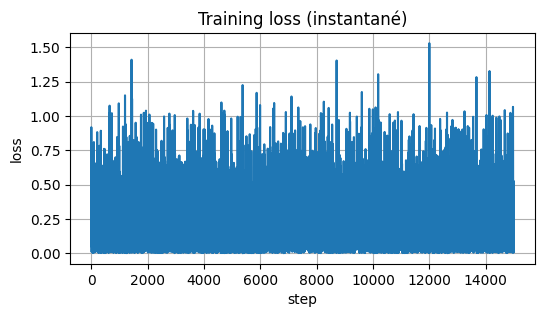

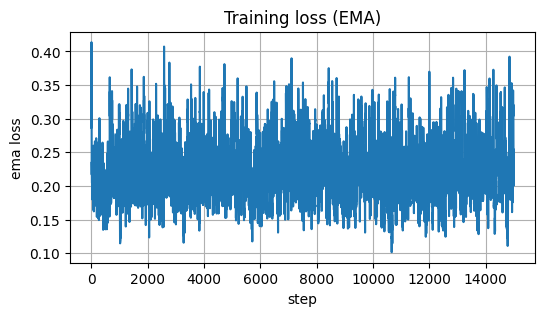

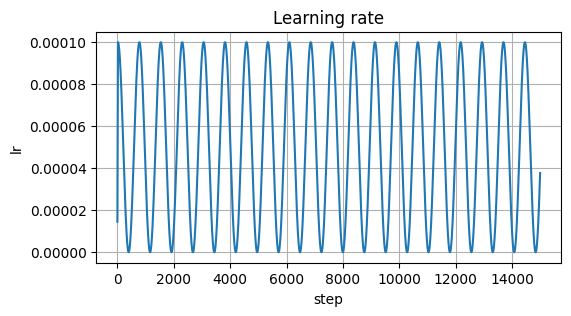

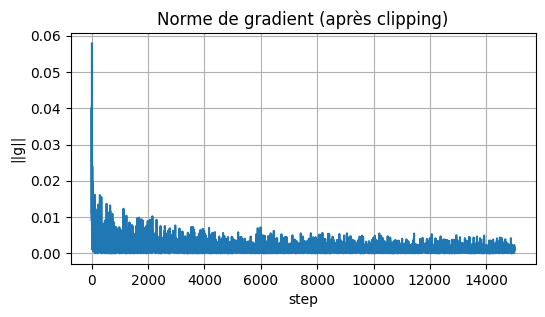

In [15]:
import matplotlib.pyplot as plt

def _plot_series(xs, ys, title, ylabel):
    plt.figure(figsize=(6,3))
    plt.plot(xs, ys)
    plt.title(title)
    plt.xlabel("step")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

_plot_series(history["step"], history["loss"], "Training loss (instantané)", "loss")
_plot_series(history["step"], history["ema"],  "Training loss (EMA)",        "ema loss")
_plot_series(history["step"], history["lr"],   "Learning rate",              "lr")
if "grad" in history:
    _plot_series(history["step"], history["grad"], "Norme de gradient (après clipping)", "||g||")


### Sauvegarde

In [16]:
# %% Save LoRA + adapter
import torch, torch.nn as nn
from diffusers.models.attention import Attention
from pathlib import Path

SAVE_PATH = Path(PROJECT_ROOT) / "checkpoints" / "lora_adapter_sd15.pth"
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)

def _export_lora_state(unet):
    state = {}
    for name, mod in unet.named_modules():
        if isinstance(mod, Attention):
            # to_q/to_k/to_v
            for attr in ("to_q", "to_k", "to_v"):
                lin = getattr(mod, attr, None)
                if isinstance(lin, LoRALinear):
                    state[f"{name}.{attr}"] = {
                        "A": lin.lora_A.detach().cpu(),
                        "B": lin.lora_B.detach().cpu(),
                        "r": int(lin.r),
                        "alpha": int(lin.alpha),
                    }
            # to_out.{0}|to_out
            key = None
            lin_out = None
            if hasattr(mod, "to_out"):
                # ModuleList [Linear, Dropout] (SD1.5)
                maybe0 = getattr(mod.to_out, "0", None)
                if isinstance(maybe0, LoRALinear):
                    key, lin_out = f"{name}.to_out.0", maybe0
                elif isinstance(mod.to_out, LoRALinear):
                    key, lin_out = f"{name}.to_out", mod.to_out
            if key and isinstance(lin_out, LoRALinear):
                state[key] = {
                    "A": lin_out.lora_A.detach().cpu(),
                    "B": lin_out.lora_B.detach().cpu(),
                    "r": int(lin_out.r),
                    "alpha": int(lin_out.alpha),
                }
    return state

from copy import deepcopy

# Variante EMA: on fabrique un state_dict "adapter_ema" si possible
adapter_ema_sd = None
try:
    tmp = deepcopy(adapter).cpu()    # copie pour ne pas toucher ton module en place
    ema.copy_to(tmp)                 # ⚠️ tu as déjà 'ema.update(adapter)' pendant l'entraînement
    adapter_ema_sd = tmp.state_dict()
    del tmp
except Exception as e:
    print("⚠️ Pas d'EMA dispo pour sauvegarde (fallback raw):", e)

ckpt = {
    "meta": {
        "unet": "sd1.5",
        "latent_res": int(LATENT_RES),
        "lora_rank": int(LORA_RANK),
        "cross_attn_dim": int(CROSS_ATTN_DIM),
    },
    "adapter": adapter.state_dict(),      # poids "courants"
    "adapter_ema": adapter_ema_sd,        # ✅ poids EMA (optionnel si None)
    "lora": _export_lora_state(unet),
}
torch.save(ckpt, SAVE_PATH)
print("💾 Sauvegardé :", SAVE_PATH)


💾 Sauvegardé : /workspace/checkpoints/lora_adapter_sd15.pth


In [17]:
# %% Load LoRA + adapter (même archi UNet/adapter)
import torch, torch.nn as nn

def _apply_lora_to_linear(parent, attr_path, r, alpha, A, B):
    parts = attr_path.split(".")
    tgt_parent = parent
    for p in parts[:-1]:
        tgt_parent = getattr(tgt_parent, p)
    last = parts[-1]
    cur = getattr(tgt_parent, last)
    # si pas déjà patché, on patch
    if not isinstance(cur, LoRALinear):
        assert isinstance(cur, nn.Linear), f"Attendu Linear pour {attr_path}, trouvé {type(cur)}"
        setattr(tgt_parent, last, LoRALinear(cur, r=r, alpha=alpha))
        cur = getattr(tgt_parent, last)
    # charger poids
    cur.lora_A.data.copy_(A)
    cur.lora_B.data.copy_(B)

def load_lora_adapter(unet, adapter, path, map_location="cpu", use_ema=False):
    ckpt = torch.load(path, map_location=map_location)
    key = "adapter_ema" if (use_ema and ("adapter_ema" in ckpt) and (ckpt["adapter_ema"] is not None)) else "adapter"
    adapter.load_state_dict(ckpt[key], strict=False)

    # ré-appliquer chaque bloc LoRA sur l'UNet
    for key_l, w in ckpt["lora"].items():
        _apply_lora_to_linear(unet, key_l, r=w["r"], alpha=w["alpha"], A=w["A"], B=w["B"])

    print("✅ LoRA + adapter",
          "(EMA)" if key=="adapter_ema" else "(raw)",
          "rechargés depuis", path)
    return ckpt

# Exemple d’usage:
# meta = load_lora_adapter(unet, adapter, SAVE_PATH, map_location="cpu")
# unet.to(DEVICE); adapter.to(DEVICE)


## Cellule 11 — Échantillonnage (par classe) avec CFG simple

In [18]:
# Vidage RAM GPU CPU
import gc, torch
gc.collect(); torch.cuda.empty_cache()


In [21]:
# =======================
# Cellule 11 — FAST CLASSWISE SAMPLER — DPMSolver++ (28 steps)
# =======================
import os, torch
from pathlib import Path
from torchvision.utils import make_grid, save_image
from PIL import Image
import numpy as np
from datetime import datetime

# Accélérations GPU sûres
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")

# ---- Params
SAVE_DIR = (PROJECT_ROOT / "samples" / "classwise") if "PROJECT_ROOT" in globals() else Path("samples/classwise")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_PATH = "/workspace/checkpoints/lora_adapter_sd15.pth"


SEED = 123
N_PER_CLASS = 4            # batch par classe
LATENT_RES = 64            # 32x32 -> 256x256
SD_SCALING  = 0.18215
NUM_INFERENCE_STEPS = 60   # DPMSolver++ ~24–36
GUIDANCE_SCALE = 3.5       # None = pas de CFG ; essaie 2.0–5.0
COND_SCALE = 3.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === EMA inference toggle ===
USE_EMA_FOR_INFER = True           # active/désactive l’EMA en inference
EMA_INFER_MODE = "ckpt"            # "swap" (EMA en mémoire) ou "ckpt" (EMA depuis checkpoint)

assert 'unet' in globals() and 'adapter' in globals(), "Instancie UNet+Adapter (et VAE si dispo) avant."

# ---- Reload LoRA+Adapter (choix d'un checkpoint par step ou dernier) ----
from pathlib import Path

# 1) PARAMS À AJUSTER ICI
USE_PERIODIC_CKPT = True                   # True = charger un checkpoint périodique "adapter_ema_stepXXXXXX.pt"
CKPT_DIR         = Path("/workspace/checkpoints")
CKPT_STEP        = 6000                    # <- mets le step que tu veux (ex: 6000, 10000) ; None = prend le dernier dispo

# 2) HELPERS
def _pick_ckpt(ckpt_dir: Path, step: int | None):
    files = sorted(ckpt_dir.glob("adapter_ema_step*.pt"))
    if not files:
        raise FileNotFoundError(f"Aucun checkpoint périodique trouvé dans {ckpt_dir}")
    if step is None:
        # prend le plus récent par numéro de step dans le nom
        files = sorted(files, key=lambda p: int(p.stem.split("step")[-1]))
        return files[-1]
    p = ckpt_dir / f"adapter_ema_step{int(step):06d}.pt"
    if not p.exists():
        raise FileNotFoundError(f"Checkpoint demandé introuvable: {p.name}")
    return p

def _load_periodic_ckpt(unet, adapter, path: Path):
    ck = torch.load(path, map_location="cpu")
    # 1) Adapter EMA si présent
    if "adapter_ema" in ck:
        adapter.load_state_dict(ck["adapter_ema"], strict=False)
        print(f"✅ Adapter (EMA) chargé depuis {path.name}")
    elif "adapter" in ck:
        adapter.load_state_dict(ck["adapter"], strict=False)
        print(f"✅ Adapter (poids courants) chargé depuis {path.name}")
    else:
        raise KeyError(f"{path.name} ne contient pas 'adapter_ema' ni 'adapter'")

    # 2) LoRA si présent (optionnel)
    if "lora" in ck and "_import_lora_state" in globals():
        try:
            _import_lora_state(unet, ck["lora"])
            print("✅ LoRA appliqué depuis le checkpoint.")
        except Exception as e:
            print(f"ℹ️ LoRA ignoré ({e})")

# 3) LOGIQUE DE CHARGEMENT
if USE_PERIODIC_CKPT:
    ckpt_path = _pick_ckpt(CKPT_DIR, CKPT_STEP)   # <- ICI tu contrôles le step
    _load_periodic_ckpt(unet, adapter, ckpt_path)
    # pour être cohérent, force le mode EMA depuis checkpoint
    USE_EMA_FOR_INFER = True
    EMA_INFER_MODE = "ckpt"
else:
    # chemin unique (ancien format)
    use_ema_from_ckpt = USE_EMA_FOR_INFER and (EMA_INFER_MODE == "ckpt")
    _ = load_lora_adapter(unet, adapter, CHECKPOINT_PATH, map_location="cpu", use_ema=use_ema_from_ckpt)
    print(f"✅ Chargé via load_lora_adapter: {Path(CHECKPOINT_PATH).name}")

# Cast + device
unet = unet.to(DEVICE).half().eval() if DEVICE.type == "cuda" else unet.to(DEVICE).eval()
adapter = adapter.to(DEVICE).half().eval() if DEVICE.type == "cuda" else adapter.to(DEVICE).eval()

# xFormers / slicing / format mémoire
try: unet.enable_xformers_memory_efficient_attention()
except: pass
try: unet.set_attention_slice("max")
except: pass
try: unet = unet.to(memory_format=torch.channels_last)
except: pass

# ---- VAE SD1.5 en GPU (rapide)
from diffusers import AutoencoderKL, DPMSolverMultistepScheduler
vae_dtype = next(unet.parameters()).dtype
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae", torch_dtype=vae_dtype).to(DEVICE).eval()
try: vae.enable_tiling()
except: pass
try: vae.enable_slicing()
except: pass

# ---- Scheduler: DPMSolver++
scheduler = DPMSolverMultistepScheduler(
    num_train_timesteps=1000,
    prediction_type="epsilon",
    algorithm_type="dpmsolver++"
)
try:
    scheduler.set_timesteps(NUM_INFERENCE_STEPS, device=DEVICE, use_karras_sigmas=True)
except TypeError:
    # certaines versions n'ont pas use_karras_sigmas
    scheduler.set_timesteps(NUM_INFERENCE_STEPS, device=DEVICE)

# ---- Utils
def to_grid(x: torch.Tensor, nrow=4, out=None):
    x = (x.clamp(-1, 1) + 1) / 2
    g = make_grid(x, nrow=nrow)
    if out: save_image(g, out)
    return g

@torch.no_grad()
def decode_latents(lat: torch.Tensor) -> torch.Tensor:
    imgs = vae.decode(lat / SD_SCALING).sample
    return imgs.clamp(-1, 1)

def _rescale_noise_cfg(noise_cfg: torch.Tensor, noise_text: torch.Tensor, s: float):
    # Ramène l’écart-type du chemin CFG à celui du chemin conditionné
    std_text = noise_text.std(dim=(1,2,3), keepdim=True)
    std_cfg  = noise_cfg.std(dim=(1,2,3), keepdim=True)
    return noise_cfg * (std_text / (std_cfg + 1e-6))


@torch.no_grad()
def sample_class_batch(class_id: int, n: int = 4, steps: int = 28):
    import time
    import torch.nn.functional as F
    dtype = next(unet.parameters()).dtype

    # latents + conditioning
    lat   = torch.randn(n, 4, LATENT_RES, LATENT_RES, device=DEVICE, dtype=dtype)
    y     = torch.full((n,), int(class_id), device=DEVICE, dtype=torch.long)

    # emb -> [B,1,C], L2-normalisé, puis scale
    emb   = adapter(y).float()
    if emb.dim() == 2:  # [B,C] -> [B,1,C]
        emb = emb.unsqueeze(1)
    emb  = F.normalize(emb, dim=-1, eps=1e-6)
    cond = (emb * COND_SCALE).to(dtype)

    # unconditional branch (zeros)
    uncond = torch.zeros_like(cond)

    # scheduler
    scheduler.set_timesteps(steps, device=DEVICE)

    t0 = time.time()
    if GUIDANCE_SCALE is None:
        # --- no-CFG ---
        for t in scheduler.timesteps:
            eps = unet(lat, t, encoder_hidden_states=cond).sample
            lat = scheduler.step(model_output=eps, timestep=t, sample=lat).prev_sample
    else:
        # --- CFG ---
        s = float(GUIDANCE_SCALE)
        for t in scheduler.timesteps:
            lat_in  = torch.cat([lat, lat], dim=0)             # [2B,4,H,W]
            cond_in = torch.cat([uncond, cond], dim=0)         # [2B,1,C]
            eps_all = unet(lat_in, t, encoder_hidden_states=cond_in).sample
            eps_u, eps_c = eps_all.chunk(2, dim=0)
            eps = eps_u + s * (eps_c - eps_u)
            eps = _rescale_noise_cfg(eps, eps_c, s)  # <-- ajout (CFG rescale)
            lat = scheduler.step(model_output=eps, timestep=t, sample=lat).prev_sample

    dt = time.time() - t0
    print(f"[timing] class {class_id}: {steps} steps en {dt:.2f}s (CFG={GUIDANCE_SCALE})")
    return decode_latents(lat).float()

# === Timeline de débruitage (évolution au fil des steps de sampling) ===
# --- Annoter la timeline avec t=... sous chaque panneau ---
def _annotate_grid(grid_tensor, labels):
    from PIL import Image, ImageDraw
    g = (grid_tensor.clamp(0,1)*255).byte().cpu()           # [3,H,W]
    g = g.permute(1,2,0).numpy()                            # HWC
    img = Image.fromarray(g)
    W, H = img.size
    cell_w = W // max(1, len(labels))
    draw = ImageDraw.Draw(img)
    for i, lab in enumerate(labels):
        draw.text((i*cell_w + 6, H-18), f"t={lab}", fill=(255,255,255))
    return img

# --- Export GIF depuis la timeline PNG ---
def save_timeline_gif(png_path, panels=None, duration_ms=140, loop=0):
    from PIL import Image
    png_path = Path(png_path)
    im = Image.open(png_path).convert("RGB")
    W, H = im.size
    panels = panels or len(TIMELINE_CAPTURES)
    cell_w = W // panels
    frames = [im.crop((i*cell_w, 0, (i+1)*cell_w, H)) for i in range(panels)]
    out_gif = png_path.with_suffix(".gif")
    frames[0].save(out_gif, save_all=True, append_images=frames[1:],
                   duration=duration_ms, loop=loop)
    print(f"🎞️ GIF sauvegardé: {out_gif}")

@torch.no_grad()
def sample_timeline(class_id: int, capture_idx=None, steps: int = NUM_INFERENCE_STEPS, seed: int = 123, out=None):
    """
    Sauvegarde une bande d'images montrant l'évolution de la génération
    au fil des steps (reverse diffusion).
    - capture_idx: liste des indices d'itération à capturer (0-based)
                    ex: [0, 5, 10, 15, 20, 25, steps-1]
    - out: Path pour enregistrer la timeline (png)
    """
    import torch.nn.functional as F
    dtype = next(unet.parameters()).dtype
    if capture_idx is None:
        capture_idx = [0, 5, 10, 15, 20, 25, steps-1]

    # fix seed
    g = torch.Generator(device=DEVICE).manual_seed(seed)

    # latents + conditioning (1 image pour lisibilité)
    lat   = torch.randn(1, 4, LATENT_RES, LATENT_RES, device=DEVICE, dtype=dtype, generator=g)
    y     = torch.full((1,), int(class_id), device=DEVICE, dtype=torch.long)

    emb   = adapter(y).float()
    if emb.dim() == 2:
        emb = emb.unsqueeze(1)
    emb  = F.normalize(emb, dim=-1, eps=1e-6)
    cond = (emb * COND_SCALE).to(dtype)
    uncond = torch.zeros_like(cond)

    # scheduler Karras si dispo
    try: scheduler.set_timesteps(steps, device=DEVICE, use_karras_sigmas=True)
    except TypeError: scheduler.set_timesteps(steps, device=DEVICE)

    frames = []
    for k, t in enumerate(scheduler.timesteps):
        if GUIDANCE_SCALE is None:
            eps = unet(lat, t, encoder_hidden_states=cond).sample
        else:
            s = float(GUIDANCE_SCALE)
            lat_in  = torch.cat([lat, lat], dim=0)
            cond_in = torch.cat([uncond, cond], dim=0)
            eps_all = unet(lat_in, t, encoder_hidden_states=cond_in).sample
            eps_u, eps_c = eps_all.chunk(2, dim=0)
            eps = eps_u + s * (eps_c - eps_u)
            # rescale CFG (stabilité)
            std_text = eps_c.std(dim=(1,2,3), keepdim=True)
            std_cfg  = eps.std(dim=(1,2,3), keepdim=True)
            eps = eps * (std_text / (std_cfg + 1e-6))

        lat = scheduler.step(model_output=eps, timestep=t, sample=lat).prev_sample

        if k in capture_idx:
            frames.append(decode_latents(lat).float())  # [1,3,H,W]

    # concat en bande horizontale
    band = torch.cat(frames, dim=0)             # [T,3,H,W]
    grid = make_grid((band.clamp(-1,1)+1)/2, nrow=len(frames))
    
    # --- PATCH: annotations "t=..." ---
    if out is not None:
        try:
            pil = _annotate_grid(grid, capture_idx)  # <= utilise ton helper
            pil.save(out)
        except Exception:
            # fallback si jamais l’annotation plante
            save_image(grid, out)
        print(f"🧪 Timeline sauvegardée: {out}")
    
    return grid
    


# ---- Classes
try:
    class_names = getattr(train_loader.dataset, "classes", None)
    classes = list(range(len(class_names)))
except Exception:
    classes = list(range(num_classes))
    class_names = None

# ---- Run (EMA swap/ckpt + seed par classe + nom de fichier informatif)
from copy import deepcopy

def _run_all_classes():
    grids = []
    for c in classes:
        torch.manual_seed(SEED + int(c))  # seed stable par classe
        imgs = sample_class_batch(c, n=N_PER_CLASS, steps=NUM_INFERENCE_STEPS)
        grid = to_grid(imgs, nrow=min(N_PER_CLASS, 4))
        label = class_names[c] if class_names else str(c)

        suffix = f"_pp{NUM_INFERENCE_STEPS}"
        suffix += f"_cfg{GUIDANCE_SCALE}" if GUIDANCE_SCALE is not None else "_nocfg"
        suffix += f"_cs{int(COND_SCALE)}"
        out = SAVE_DIR / f"{label.replace('/', '_')}_dpms{suffix}_n{N_PER_CLASS}.png"

        save_image(grid, out)
        grids.append((label, out))
        print(f"🖼️ Classe {label} — {N_PER_CLASS} samples | steps={NUM_INFERENCE_STEPS} | latent={LATENT_RES}² → img={LATENT_RES*8}px")
    print("✅ Grilles sauvegardées :")
    for label, p in grids:
        print(f"  - {label}: {p}")

# ---- Options timeline (sampling)
# Génère des indices régulièrement espacés entre 0 et steps-1
def make_captures(n_steps: int, n_panels: int = 8, include0: bool = True, includelast: bool = True):
    import numpy as np
    n_panels = max(2, int(n_panels))
    idx = np.linspace(0, n_steps - 1, num=n_panels, dtype=int)
    extra = []
    if include0:   extra.append(0)
    if includelast: extra.append(n_steps - 1)
    if extra:
        idx = np.unique(np.concatenate([idx, np.array(extra, dtype=int)]))
    return idx.tolist()

MAKE_TIMELINE = True
TIMELINE_CLASS = 0
TIMELINE_N_PANELS = 8  # ← ajuste librement (ex: 8, 10, 12)
# capture indices calculés automatiquement en fonction de NUM_INFERENCE_STEPS
TIMELINE_CAPTURES = make_captures(NUM_INFERENCE_STEPS, n_panels=TIMELINE_N_PANELS)

from copy import deepcopy

def _run_with_optional_timeline():
    # Grilles par classe
    _run_all_classes()
    # Timeline (optionnelle)
    if MAKE_TIMELINE:
        # ⇩ recalcule à chaque run pour rester synchro avec NUM_INFERENCE_STEPS
        globals()["TIMELINE_CAPTURES"] = make_captures(NUM_INFERENCE_STEPS, n_panels=TIMELINE_N_PANELS)
        
        tl_out = SAVE_DIR / f"timeline_cls{TIMELINE_CLASS}_pp{NUM_INFERENCE_STEPS}" \
                            f"_cfg{GUIDANCE_SCALE}_cs{int(COND_SCALE)}.png"
        _ = sample_timeline(
            class_id=TIMELINE_CLASS,
            capture_idx=TIMELINE_CAPTURES,
            steps=NUM_INFERENCE_STEPS,
            seed=SEED,
            out=tl_out
        )
        # 🔽 Création du gif
        save_timeline_gif(tl_out, panels=len(TIMELINE_CAPTURES), duration_ms=200)

if USE_EMA_FOR_INFER and (EMA_INFER_MODE == "swap"):
    print("[EMA infer] mode=swap → on copie l’EMA en mémoire pour l’inférence.")
    _backup_sd = deepcopy(adapter.state_dict())
    try:
        ema.copy_to(adapter)   # nécessite 'ema' créé pendant l'entraînement
        _run_with_optional_timeline()
    except Exception as e:
        print(f"[EMA infer] swap impossible ({e}) → utilisation des poids courants.")
        _run_with_optional_timeline()
    finally:
        try:
            adapter.load_state_dict(_backup_sd, strict=False)
            print("[EMA infer] adapter restauré (poids d’origine).")
        except Exception as e:
            print(f"[EMA infer] restauration impossible ({e}).")
else:
    if USE_EMA_FOR_INFER and (EMA_INFER_MODE == "ckpt"):
        print("[EMA infer] mode=ckpt → adapter chargé avec les poids EMA du checkpoint.")
    else:
        print("[EMA infer] désactivé → on utilise les poids courants.")
    _run_with_optional_timeline()



/tmp/ipykernel_7962/656900465.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")


✅ Adapter (EMA) chargé depuis adapter_ema_step006000.pt
[EMA infer] mode=ckpt → adapter chargé avec les poids EMA du checkpoint.
[timing] class 0: 60 steps en 33.72s (CFG=3.5)
🖼️ Classe 0 — 4 samples | steps=60 | latent=64² → img=512px
✅ Grilles sauvegardées :
  - 0: /workspace/samples/classwise/0_dpms_pp60_cfg3.5_cs3_n4.png
🧪 Timeline sauvegardée: /workspace/samples/classwise/timeline_cls0_pp60_cfg3.5_cs3.png
🎞️ GIF sauvegardé: /workspace/samples/classwise/timeline_cls0_pp60_cfg3.5_cs3.gif
